# Table of Contents
* [1. Auto Parking in case of Strong Wind](#1.-Auto-Parking-in-case-of-Strong-Wind)
* [2. Here the study really starts](#2.-Here-the-study-really-starts)
	* [2.1 Typical Park and Observation times](#2.1-Typical-Park-and-Observation-times)
	* [2.2 What nights did we park a lot?](#2.2-What-nights-did-we-park-a-lot?)
	* [2.3 Five years of Parking](#2.3-Five-years-of-Parking)
	* [2.4 Some examples Nights Nov. 2017](#2.4-Some-examples-Nights-Nov.-2017)
	* [2.5 Some more example Nights Jan 2014](#2.5-Some-more-example-Nights-Jan-2014)


# 1. Auto Parking in case of Strong Wind

In this little document I want to study how a proposed algorihm to park FACT in case of strong wind would have behaved based on the historical wind speed data we have.

The Algorithm was proposed by Adrian and goes like this:
 * We base our decision on the MAGIC weather station measurements, in particular
 * We look only at the maximum wind speed `v_max` and not at the average speed `v`.
 * We define "a gust" when `v_max > LIMIT` is measured, where `LIMIT = 50 km/h`
 * We count the number of gusts in the last 20 minutes and call this `g_20`
 * If more than two bursts were seen in the last **20 minutes** we want to park at least 20 minutes.
 * We want to only resume observation, if `g_20` is below 1, i.e. if not a single burst has been seen in the last 20 minutes.
 
Below you'll first see me importing all the necessary libraries and defining some functions I'll need further down.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np



from datetime import datetime, timedelta

from astropy.time import Time
from astropy import units as u

from fact.instrument import constants

from fact.instrument.constants import LOCATION
import astral

import os.path
from glob import glob
from tqdm import tqdm
import pandas as pd
from fact.auxservices import AuxService

def combine_fits_to_h5(
    glob_expr='aux/*.MAGIC_WEATHER_DATA.fits'
):
    df = pd.concat(
        [
            AuxService.read_file(path)
            for path in tqdm(sorted(glob(glob_expr)))
        ],
        ignore_index=True
    )
    df['Time'] = pd.to_datetime(df.Time, unit='d')
    df.set_index('Time', inplace=True)
    df.sort_index(inplace=True)
    df.to_hdf("MAGIC_WEATHER_DATA.h5", "MAGIC_WEATHER_DATA")
    return df

    
fact = astral.Location((
    'fact', 
    'La Palma',
    LOCATION.lat.deg, 
    LOCATION.lon.deg, 
    'WET', 
    LOCATION.height.value
))
fact.solar_depression='astronomical'

def plot_example_night(df, pd_timestamp):
    plt.figure(figsize=(12, 4))
    sl = slice(
        fact.dusk(pd_timestamp.date() - timedelta(days=1), local=False),
        fact.dawn(pd_timestamp.date(), local=False)
    )
    df.v_max[sl].plot(lw=1, marker='.', linestyle=':')
    (20 * df.park_20[sl]).plot(lw=0, marker='.')
    plt.grid()

def edge_zones(boolean_array, rising=True):
    ''' return start, stop indices for "zones" of steady state
    
    rising: boolean
        return zones starting with a rising edge
    
    returns: (starts, ends)
        starts: 1D array of integer indices into boolean_array
        ends: 1D array of integer indices into boolean_array
    '''
    diff = np.diff(boolean_array.astype(int))
    where = np.nonzero(diff)[0]
    # 1 is rising edge; -1 is falling edge
    what = diff[where] 
    
    if rising != (what[0] == 1):
        where = where[1:]
        what = what[1:]
    
    if len(where) % 2:    
        where = where[:-1]
        what = what[:-1]
    zones = where.reshape(-1, 2)
    starts = zones[:, 0]-1
    ends = zones[:, 1]+1
    return starts, ends

def zone_durations(boolean_array, time_index, rising=True):
    start, stop = edge_zones(boolean_array, rising=rising)
    return time_index[stop] - time_index[start]

In order to quickly work with our aux data, I first combine it into an hdf5 file. 
This I only do once, after I copied the aux files to my local machine.

In [2]:
if not os.path.isfile('MAGIC_WEATHER_DATA.h5'):
    df = combine_fits_to_h5('aux/*.MAGIC_WEATHER_DATA.fits')
else:
    df = pd.read_hdf('MAGIC_WEATHER_DATA.h5')

100%|██████████| 1782/1782 [00:39<00:00, 44.67it/s]


# 2. Here the study really starts

First we'll implement the proposed algorithm. So we findout if there was a strong wind gust or not.

In [3]:
LIMIT = 50 # km/h
df['is_strong_gust'] = df.v_max > LIMIT

We count the number of gusts within the last **20minutes**. We want to base our decisions on this number, we call it `g_20`

In [4]:
df['g_20'] = df.is_strong_gust.rolling('20min').sum()

If there are more than 2 strong gusts within the last 20 minutes we want to start parking.
And only when there are not more than zero gusts within the last 20 minutes we want to stop.

In [5]:
df['start_20'] = (df.g_20 > 2).astype(int).diff() > 0
df['stop_20'] = (df.g_20 > 0).astype(int).diff() < 0

So "start_20" here means: start parking due to strong wind, and "stop_20" means: We can stop now parking.
The way these signals are generated, we can get a "stop" signal without a previous "start" signal, of course we can just ignore that. 

Or we can get a "start" signal some minutes after a previous "start" signal without an intermediate "stop" signal. In that case we just ignore the duplicates. 

(I was not able to vectorize that, so I used Fortran for this :-D)

In [6]:
%load_ext fortranmagic

In [7]:
%%fortran
subroutine park_logic(start, stop, park)
    logical, intent(in) :: start(:), stop(:)
    logical, intent(out) :: park(size(start))
            
    logical::current_state
    current_state = .false.
    
    do i=1, size(start)
        current_state = (current_state .and. (.not. stop(i))) .or. start(i)
        park(i) = current_state
    end do
    
end subroutine

In [8]:
df['park_20'] = park_logic(df.start_20.values, df.stop_20.values)

Now we have a boolean signal "park_20" which goes high, when we think we should park, and goes low, when we think we should not park anymore.
Below we see a few windy days in November 2017. We see nice big areas where the orange "park signal" is high, that means we would have parked without pause. 

One goal of this algorithm was to suppress quick useless: "park - unpark - park" sequences, which can be nicely observed here.

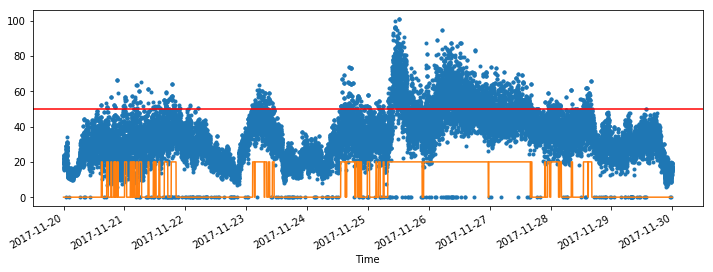

In [9]:
plt.figure(figsize=(12, 4))
sl = slice('2017-11-20', '2017-11-29')
df.v_max[sl].plot(lw=0, marker='.')
(20 * df.park_20[sl]).plot()
plt.axhline(50, color='r')
None

## 2.1 Typical Park and Observation times

We want to quantize how long a the minimum "park" time is, after all it is designed to be 20 minutes. Also we want to see how long the minimum observation time is.

In [10]:
park_times_in_minutes = zone_durations(
    df.park_20, df.index, rising=True).total_seconds() / 60
obs_times_in_minutes = zone_durations(
    df.park_20, df.index, rising=False).total_seconds() / 60

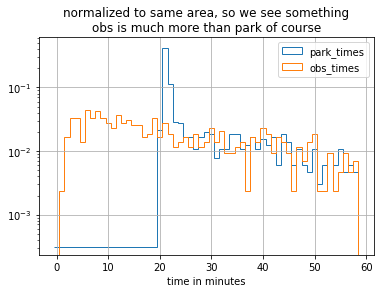

In [11]:
args = dict(
    bins=np.arange(0, 60)-0.5,
    histtype='step',
    log=True,
    normed=True
)
plt.hist(
    park_times_in_minutes, 
    label='park_times',
    **args
)
plt.hist(
    obs_times_in_minutes,
    label='obs_times',
    **args
)
plt.grid()
plt.legend()
plt.xlabel('time in minutes')
plt.title('normalized to same area, so we see something\n'
         'obs is much more than park of course')
None

## 2.2 What nights did we park a lot?

Up do now we looked at day & night data, but we are more interested in nights. Actually I think we would like to know which nights the proposed algorithm would let us park a lot.

So let's make a sum for every day(i.e. night) and find out what part of the night we would have parked.

In [12]:
days = pd.date_range(df.index.min().date(), df.index.max())

D = pd.DataFrame({
    'date': days,
    'sun_set': pd.to_datetime([fact.dusk((day-np.timedelta64(24, 'h')).date(), local=False) for day in days]),
    'sun_rise': pd.to_datetime([fact.dawn(day.date(), local=False) for day in days]),
})
D['night_length'] = D.sun_rise - D.sun_set
D.set_index('date', drop=False, inplace=True)

In [13]:
def calc_time_of_park_on_or_off(row, park_on):
    part = df[row['sun_set']:row['sun_rise']].copy()
    part.reset_index(inplace=True)
    part['dt'] = part.Time.diff()
    part = part[1:]

    park = part[part.park_20 == park_on]
    if not len(park):
        return np.timedelta64(0)
    
    return park.dt.sum()

In [14]:
%%time
D['park_time'] = D.apply(calc_time_of_park_on_or_off, axis=1, park_on=True)
D['obs_time'] = D.apply(calc_time_of_park_on_or_off, axis=1, park_on=False)
D['park_fraction'] = (D.park_time / (D.park_time + D.obs_time)).fillna(0.)

CPU times: user 8.17 s, sys: 12 ms, total: 8.18 s
Wall time: 8.18 s


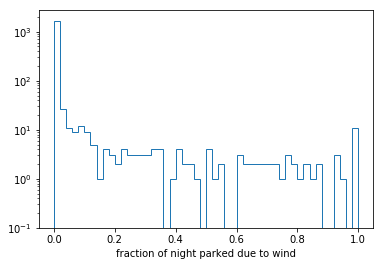

In [15]:
plt.hist(
    D.park_fraction,
    bins=50,
    histtype='step',
    log=True
)
plt.xlabel('fraction of night parked due to wind');

This is pretty much what one would expect, a lot of the time, we do not park at all, but sometimes, we park the entire night.

## 2.3 Five years of Parking

Let's now look at the total 5 years in one plot is not so nice, so lets look at 5 plots, one per year.

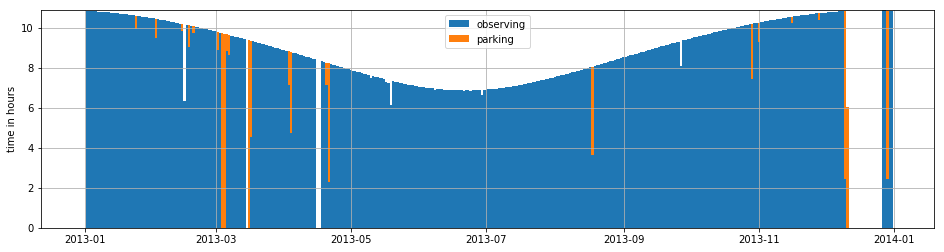

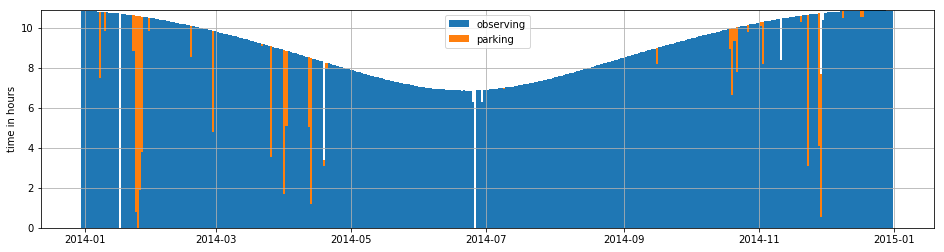

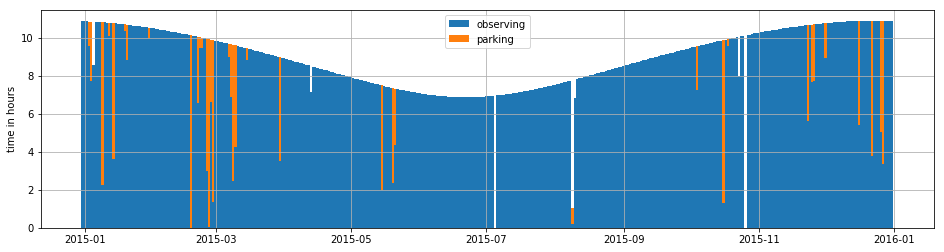

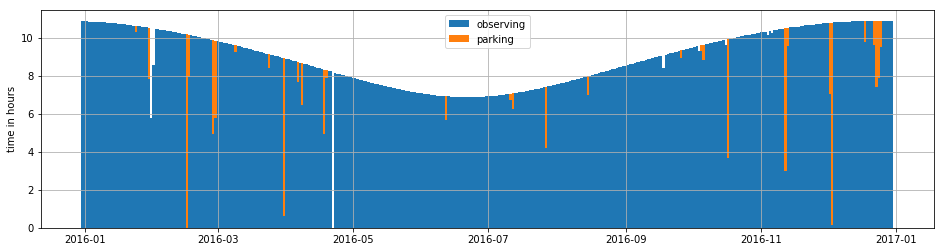

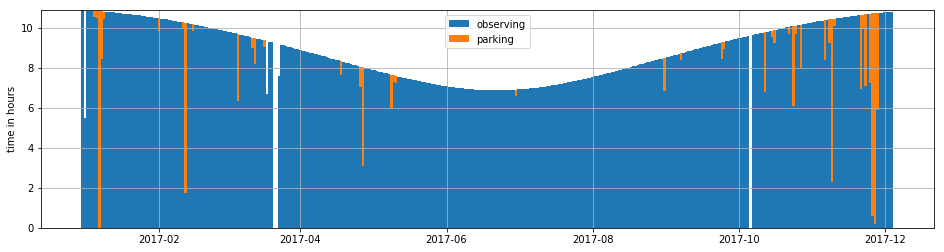

In [16]:
for start_date in pd.date_range("2012", freq='Y', periods=5):
    X = D[start_date:start_date+np.timedelta64(1, 'Y')]
    
    plt.figure(figsize=(16, 4))

    plt.bar(
        X.date,
        X.obs_time.dt.total_seconds() / 3600.,
        width=1,
        label='observing'
    )
    plt.bar(
        X.date,
        X.park_time.dt.total_seconds() / 3600.,
        bottom=X.obs_time.dt.total_seconds() / 3600.,
        width=1,
        label='parking'
    )
    plt.legend()
    plt.ylabel('time in hours')
    plt.grid()

All this is still based on weather station data, so when there was no weather station data, then (in this plot) we have neither observed nor parked, so the bar is empty.

## 2.4 Some examples Nights Nov. 2017

The following plots show some example nights from November 2017, which were particularly windy.

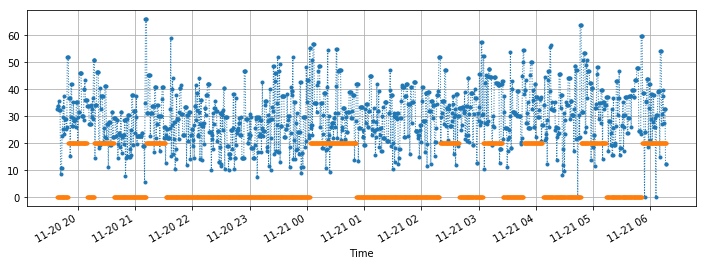

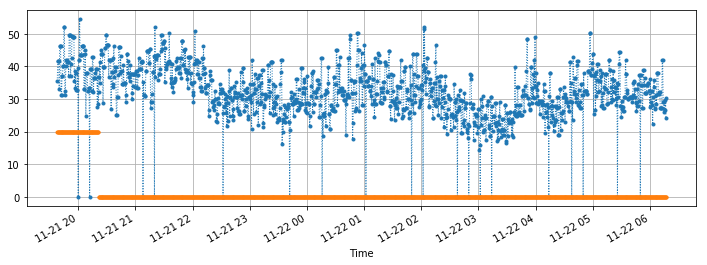

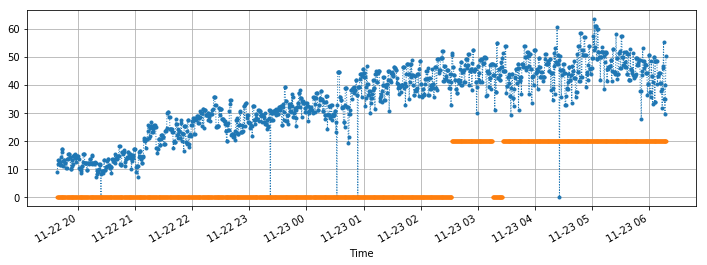

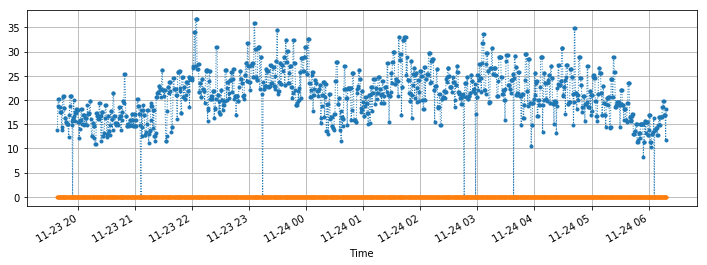

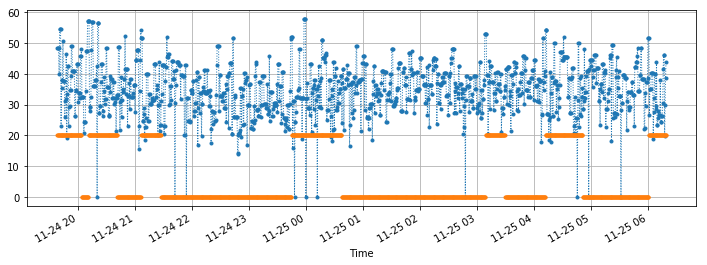

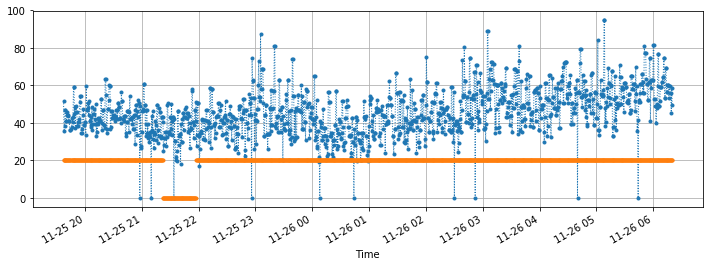

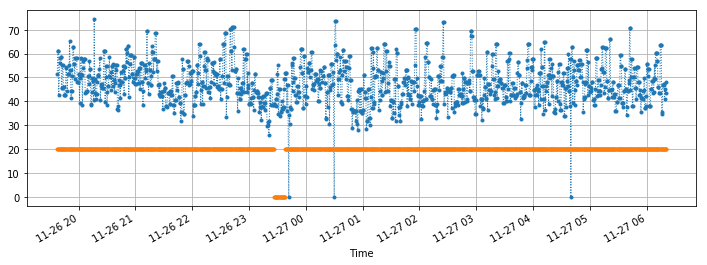

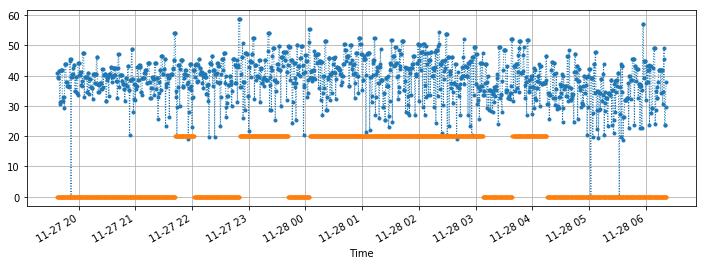

In [17]:
for date in pd.date_range('2017-11-21', periods=8):
    plot_example_night(df, date)

## 2.5 Some more example Nights Jan 2014

In some earlier report I used to show some example nights from Jan 2014, so let's look at the same nights also here

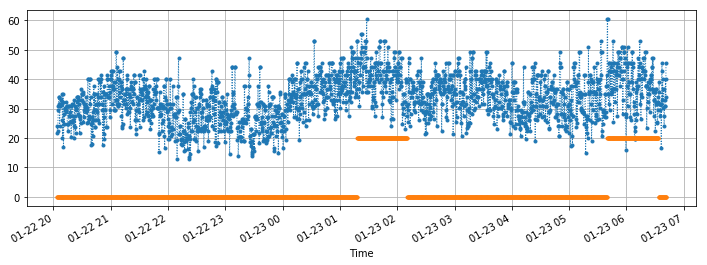

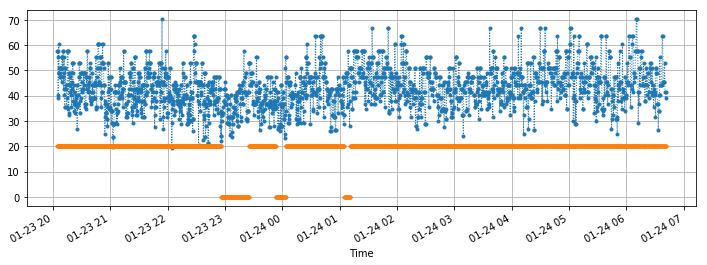

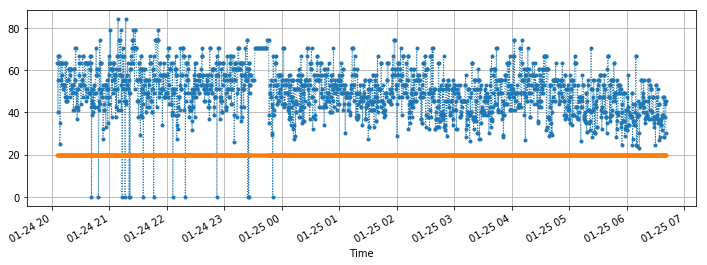

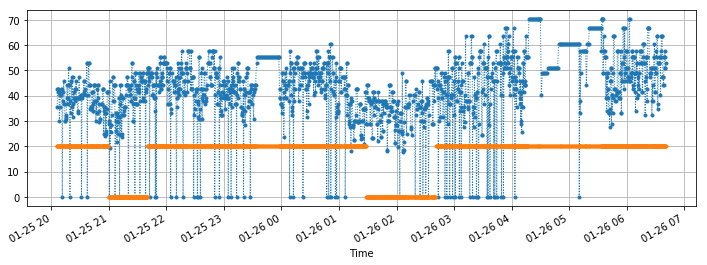

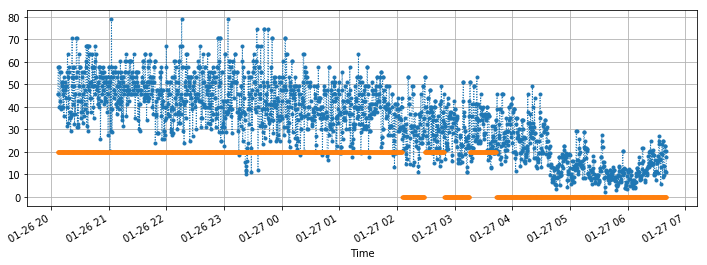

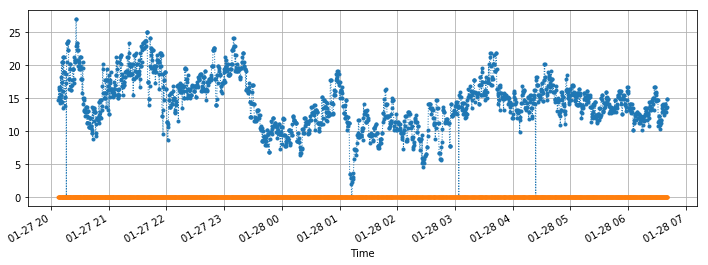

In [18]:
for date in pd.date_range('2014-01-23', periods=6):
    plot_example_night(df, date)
